In [1]:
# Library Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.model_selection import GridSearchCV
import re
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

# The Data
<hr style="border: 1.5px solid #003262; margin-top: 0; padding-top: 0;" />

This project aims to create a model that classifies emails as spam or not spam (referred to as "ham") using features generated from the text in the email. The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/). It consists of email messages and their labels (0 for ham, 1 for spam). The training dataset contains 8,348 labeled examples, and the test set contains 1,000 unlabeled examples. The dataset is from 2004, so the contents of emails might be very different from modern-day emails.

The `train` dataset contains labeled data with columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

In [2]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [3]:
# Loading training and test datasets
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lowercase as the first step of text processing.
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


## Data Cleaning

First, I checked if the data contained any missing values and replaced these missing values with filler values, i.e. missing values in the `subject` or `email` columns are replaced with empty strings. I printed out the number of `NaN` values in each column before and after data cleaning to verify if data cleaning was performed successfully.

In [4]:
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


## Intial Analysis

An initial look at the data reveals that spam emails tend to contain HTML tags including `<head>` or `<body>` labels which the ham emails appear to not so.

I split the training data into separate training and validation datasets to train and validate the model and assess the classifier's performance. Performed a 90/10 train-validation split on the training dataset. I used `random_state=42` for reproducibility purposes. 

In [5]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# Feature Engineering 
<hr style="border: 1.5px solid #003262; margin-top: 0; padding-top: 0;" />

Email classification is a **binary classification** problem, so Logistic Regression is a suitable model to train a classifier. I extracted a numerical feature matrix $\mathbb{X}$ o train the Logistic Regression model and a vector of corresponding labels $Y$. As a result, I derive numerical features from the qualitative email dataset.

Each row in the $\mathbb{X}$ matrix represents an email and each column contains one feature for all emails. First, I constructed a function to check if each word in a list of `words` is included in the emails. The function returns a 2-dimensional array: if the $j$-th word in `words` is present at least once in the $i$-th email, the output array holds a value of $1$ at the position $(i, j)$ and $0$ otherwise. 

In [6]:
def words_in_texts(words, texts):
    """
    Args:
        words (list): Words to find.
        texts (Series): Strings to search in.
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, d) where 
        n is the number of texts and d is the number of words.
    """
    texts = texts.copy().reset_index()
    name = texts.columns[-1]
    texts = texts[name]
    indicator_array = np.zeros((texts.shape[0], len(words)))
    for text in range(texts.shape[0]):
        for word in range(len(words)):
            if (words[word] in texts[text]):
                indicator_array[text][word] = 1     
    return indicator_array

In [7]:
interest = ['hello', 'free']
output = words_in_texts(interest, train['email'])
output

array([[0., 1.],
       [0., 0.],
       [1., 1.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

# Exploratory Data Analysis
<hr style="border: 1.5px solid #003262; margin-top: 0; padding-top: 0;" />

At first, I surveyed the data to find words that better capture the distinction between spam and ham emails and observed the occurrences of words in spam and ham emails. I considered words' occurrences to be an accurate feature if there existed a clear distinction in the words' proportion across spam and ham classes. 

To identify words with distinct occurrences across the classes of emails,  I visualized the proportion of emails in each class containing a particular set of words with a bar plot. 

Scanning the dataset and from domain knowledge, I identified a list of words of interest `["title", "free", 'off', 'day', 'best', 'body', 'html', 'business', 'offer', 'please', 'thank', 'org', 'reply', 'card']` and plotted the proportion of each word across ham and spam classes:

In [8]:
def count_symbol(input_string):
    symbol_pattern = re.compile(r'[^a-zA-Z0-9\s]')
    symbol_count = symbol_pattern.findall(input_string)
    return len(symbol_count)

def count_url(input_string):
    punctuation_pattern = re.compile(r'https?://(?:www\.)?[a-zA-Z0-9-]+(?:\.[a-zA-Z]{2,})+(?:[/?=&#][a-zA-Z0-9-._]*)*')
    punctuations = punctuation_pattern.findall(input_string)
    return len(punctuations)

def has_re_prefix(input_string):
    return 1 if "Re" in input_string else 0

def count_common_punctuations(input_string):
    punctuation_pattern = re.compile(r'[' + re.escape(r'''[@.?!,;:—–-()[]{}‘“”‘’]''') + ']')
    punctuations = punctuation_pattern.findall(input_string)
    return len(punctuations)


def count_uncommon_punctuations(input_string):
    punctuation_pattern = re.compile(r'[' + re.escape(r'''[#$%&\*+/<=>\\^_`|~]''') + ']')
    punctuations = punctuation_pattern.findall(input_string)
    return len(punctuations)

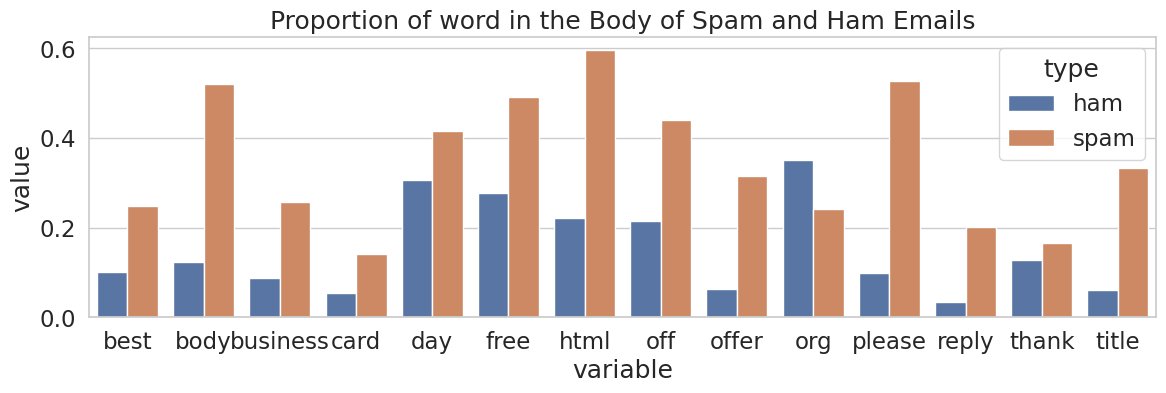

In [9]:
plt.figure(figsize=(12,4))
words = ["title", "free", 'off', 'day', 'best', 'body', 'html', 'business', 'offer', 'please', 'thank', 'org', 'reply', 'card']
target = pd.DataFrame(columns= words + ["type"])
target[words] = words_in_texts(words, train.email).astype(int)
target["type"] = ["spam" if (i == 1) else "ham" for i in train.spam ]
m = target.melt('type')
a = m.groupby(["type", "variable"]).agg({'value': lambda x: x.sum()/x.size})
a = a.reset_index(level=[0,1])
sns.barplot(a, x='variable', y='value', hue='type')
plt.tight_layout()
plt.title('Proportion of word in the Body of Spam and Ham Emails')
plt.show()

Similarly, I identified words of interest in the emails' subjects (`['stop', 'help', 'urgent', 'call', 'money', 'sell', 'buy', 'action', "don't", 'hey']`) and plotted the proportion of each word across ham and spam classes. 

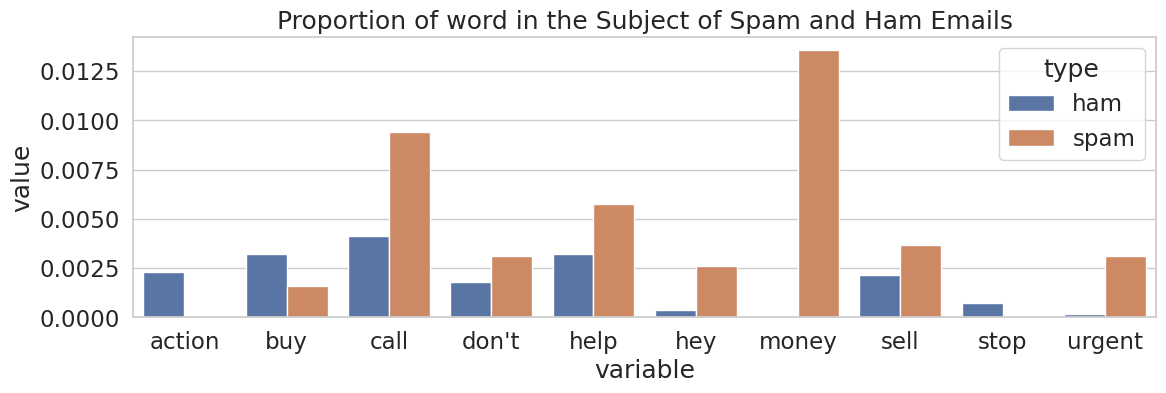

In [10]:
plt.figure(figsize=(12,4))
words = ['stop', 'help', 'urgent', 'call', 'money', 'sell', 'buy', 'action', "don't", 'hey']
target = pd.DataFrame(columns= words + ["type"])
target[words] = words_in_texts(words, train.subject).astype(int)
target["type"] = ["spam" if (i == 1) else "ham" for i in train.spam ]
m = target.melt('type')
a = m.groupby(["type", "variable"]).agg({'value': lambda x: x.sum()/x.size})
a = a.reset_index(level=[0,1])
sns.barplot(a, x='variable', y='value', hue='type')
plt.tight_layout()
plt.title('Proportion of word in the Subject of Spam and Ham Emails')
plt.show()

I decided to include the words provided in the above bar plots (words in emails' `body` and `subject`). 

Furthermore, I decided to include additional features to more accurately capture spam and ham emails. I included the count of website URLs in the body of the emails. I also looked at the counts of common English punctuation marks, as well as uncommon punctuation marks, in the body and subject of emails. Moreover, I included the count of characters in the bodies of the emails and whether the subject of the email contained 'Re', as an indication that it was a forwarded email as features in my model.

I decided to survey the frequency of punctuations across ham and spam emails. Specifically, I looked at common English punctuation marks, including Period (.). Question Mark (?), Exclamation Point (!), Comma (,), Semicolon (;), Colon (:), Em Dash (—), En Dash (–), Hyphen (-), Parentheses (()), Brackets ([]), Braces ({}), Apostrophe (‘), Quotation Marks (“”), Single Quotation Marks (‘’), and Ellipsis (...). In addition, considering the context of this analysis, I treated the at (@) symbol as a common English punctuation, as it appears in every email address: there are a lot of uses of the symbol, for example, one  mentioning or sharing another person's email address. All other punctuation marks were classified as uncommon punctuation. First, I found the proportion of common and uncommon punctuation marks to all symbols, that is non-letter, non-numeric, and non-space characters, per email. I then took the average proportion of common and uncommon punctuation across spam and ham classes.

Using a heat map, I surveyed the average proportions of common English punctuation marks and uncommon punctuation marks across spam and ham emails. The visualization reveals that spam emails contain a high average proportion of uncommon punctuation marks compared to ham emails, which implies that the proportion of uncommon punctuation marks to all symbols in email bodies could be used as a feature in the model. In addition, ham emails demonstrate a higher average proportion of common punctuation marks compared to spam emails. The visualization implies that the proportion of common English punctuation marks and uncommon punctuation marks to all symbols in the body of emails show clear distinctions across spam and ham emails, making them good features to be included in the model.

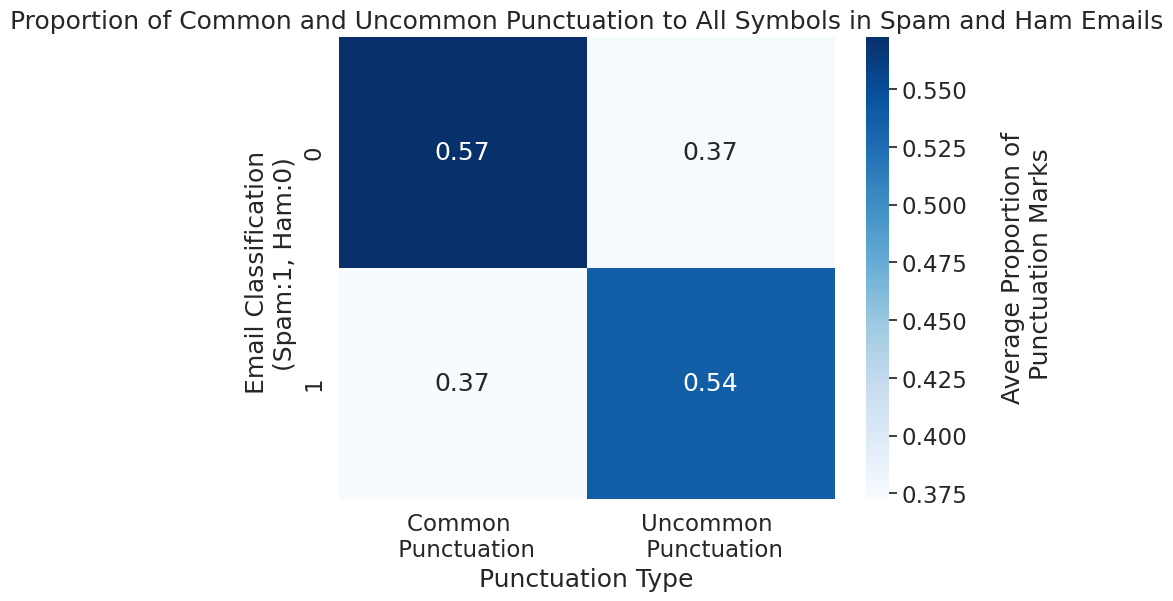

In [11]:
epa_train = train.copy()
epa_train['Common \n Punctuation'] = epa_train['email'].apply(count_common_punctuations)
epa_train['Uncommon \n Punctuation'] = epa_train['email'].apply(count_uncommon_punctuations)

epa_train['TotalChar'] = epa_train['email'].apply(count_symbol)
epa_train['CommonFreq'] = epa_train['Common \n Punctuation'] / epa_train['TotalChar']
epa_train['UncommonFreq'] = epa_train['Uncommon \n Punctuation'] / epa_train['TotalChar']
epa_train_grouped = epa_train.groupby('spam').agg({'CommonFreq': 'mean', 'UncommonFreq': 'mean'})
epa_train_grouped

epa_train

heatmap_data = epa_train_grouped[['CommonFreq', 'UncommonFreq']]
heatmap_data = heatmap_data.rename(columns={'CommonFreq': 'Common \n Punctuation', 'UncommonFreq': 'Uncommon \n Punctuation'})

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt='.2f', cbar_kws={'label': ' \n Average Proportion of \n Punctuation Marks'})
plt.title('Proportion of Common and Uncommon Punctuation to All Symbols in Spam and Ham Emails')
plt.xlabel('Punctuation Type')
plt.ylabel('Email Classification \n (Spam:1, Ham:0)')
plt.show()

In [15]:
def count_in_texts(data):
    data = data.copy().reset_index()
    words = ["title", "free", 'off', 'day', 'best', 'body', 'html', 'business', 'offer', 'please', 'thank', 'org', 'reply', 'stop', 'help', 'urgent', 'call', 'money', 'sell', 'buy', 'action', "don't", 'hey']
    subject_words = ['stop', 'help', 'urgent', 'call', 'money', 'sell', 'buy', 'action', "don't", 'hey']
    
    indicator_array = np.zeros((data['email'].shape[0], len(words) + len(subject_words) + 7))
    
    for text in range(data['email'].shape[0]):
        # Look if the word is in the Email
        for word in range(len(words)): 
            if (words[word] in data['email'][text]):
                indicator_array[text][word] = 1

        # Look if the word is in the Email
        for word in range(len(subject_words)):
            if (subject_words[word] in str(data['subject'][text])):
                indicator_array[text][len(words) + word] = 1

        # The number of common English punctuation in the Email
        indicator_array[text][-7] = count_url(str(data['email'][text]))
 
        # The number of common English punctuation in the Email
        indicator_array[text][-6] = count_common_punctuations(str(data['email'][text])) / count_symbol(str(data['email'][text]))

        # The number of uncommon punctuation in the Email
        indicator_array[text][-5] = count_uncommon_punctuations(str(data['email'][text])) / count_symbol(str(data['email'][text]))

        # The number of words in the Email
        indicator_array[text][-4] = len(data['email'][text])

        # Does the Subject contain 'Re'
        indicator_array[text][-3] = has_re_prefix(str(data['subject']))

        # The number of common English punctuation in the Subject
        indicator_array[text][-2] = count_common_punctuations(str(data['subject'][text]))

        # The number of uncommon punctuation in the Subject
        indicator_array[text][-1] = count_uncommon_punctuations(str(data['subject'][text]))
        
    return indicator_array

After defining the features to include in the model, I created the feature matrix and the labels array and fitted the Logistic Regression Model.

In [16]:
# Define your processing function, processed data, and model here. 
# You may find it helpful to look through the rest of the questions first!
X_train = count_in_texts(train)
Y_train = np.array(train['spam'])

model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.8960468521229868


It was interesting to see that different combinations of the words in the body and the subject of the emails resulted in different accuracies. When I excluded certain words there would be significant change in the acuracy whereas when I added others, the accuracy wouldn't change drastically, often staying the same. It was interesting to survey the accuracy of different words and pick the one that works better. It was surprising to see that even though some words demonstrate a very drastic difference in frequency across spam and ham emails, when included in the model, they would not change the accuracy at all. This happened a couple of times (e.g. when I included the word 'action'). Also, some features, such as the word count in the body of emails, actually reduced my model's accuracy when included.

# Validate Model
<hr style="border: 1.5px solid #003262; margin-top: 0; padding-top: 0;" />

Using the validation dataset `val`, I experimented with different regularization types (L1 and L2) with various regularization strengths. I performed cross-validation using `GridSearchCV` to tune hyperparameters (e.g. regularization strength) and evaluate the model's performance.

In [17]:
logreg = LogisticRegression(solver='liblinear')

# Parameter grid for L1 and L2 regularization
param_grid = {
    'penalty': ['l1', 'l2'], 
    'C': np.logspace(-4, 4, 10)
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, Y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
val = val.reset_index().drop(columns="index")
X_val = count_in_texts(val)
y_pred = best_model.predict(X_val)

# Validation Metrics
print("Validation Classification Report:\n", classification_report(val['spam'], y_pred))
print("Confusion Matrix:\n", confusion_matrix(val['spam'], y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 10000.0, 'penalty': 'l2'}
Best Cross-Validation Accuracy: 0.897509995543755
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       613
           1       0.89      0.68      0.77       222

    accuracy                           0.89       835
   macro avg       0.89      0.82      0.85       835
weighted avg       0.89      0.89      0.89       835

Confusion Matrix:
 [[594  19]
 [ 72 150]]


# Assess Model Performance
<hr style="border: 1.5px solid #003262; margin-top: 0; padding-top: 0;" />

I plotted the ROC Curve to observe the best model accuracy using threshold values of the range `[0, 1]`.

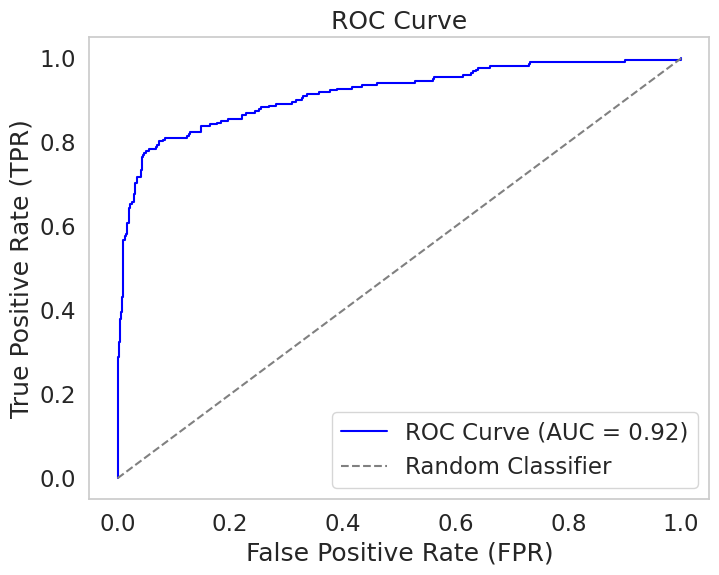

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_val_prob = best_model.predict_proba(X_val)[:, 1]

# ROC metrics
fpr, tpr, thresholds = roc_curve(Y_val, y_val_prob)
auc_score = roc_auc_score(Y_val, y_val_prob)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show();